In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# evaluation metrix
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# pickle
import pickle

# overfitting 
from sklearn.linear_model import Ridge, Lasso

# Hyperparamter tuning
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Future warnings

#### 1) Problem Statement

In [3]:
Predict medical insurance price/ premium base on independent features

#### 2) Data Gathering

In [8]:
df = pd.read_csv("medical_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


#### 3) EDA

#### Missing

In [9]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
df.isna().mean() # mssing in %

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [11]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


#### Outliers detection

<Axes: >

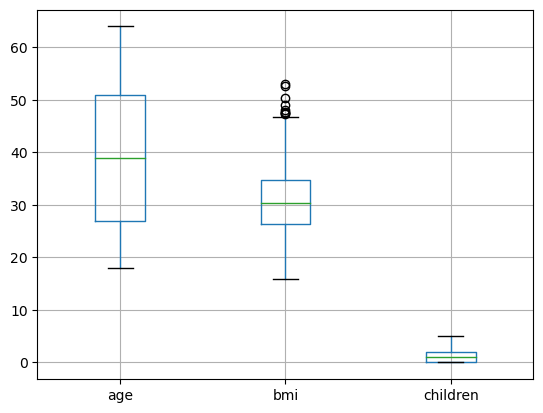

In [12]:
df[["age","bmi","children"]].boxplot()

In [7]:
sns.boxplot(x=df["bmi"])

C:\Users\shilp\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='bmi'>

In [13]:
q1 = df["bmi"].quantile(0.25)
q2 = df["bmi"].quantile(0.50)
q3 = df["bmi"].quantile(0.75)
iqr = q3 - q1
uppertail = q3 + 1.5 *iqr
print(uppertail)
df.loc[(df["bmi"]>uppertail)]

47.290000000000006


,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.32540
286,46,female,48.07,2,no,northeast,9432.92530
401,47,male,47.52,1,no,southeast,8083.91980
543,54,female,47.41,0,yes,southeast,63770.42801
847,23,male,50.38,1,no,southeast,2438.05520
860,37,female,47.60,2,yes,southwest,46113.51100
1047,22,male,52.58,1,yes,southeast,44501.39820
1088,52,male,47.74,1,no,southeast,9748.91060
1317,18,male,53.13,0,no,southeast,1163.46270


In [14]:
df["sex"].unique()

array(['female', 'male'], dtype=object)

In [15]:
df.rename(columns={"sex":"gender"},inplace=True)

In [16]:
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [17]:
df["region"]= pd.to_numeric(df["region"],errors='coerce')

In [18]:

df.corr()

ValueError: could not convert string to float: 'female'

In [19]:
df1 = df.drop(["charges","gender","smoker","region"],axis=1)
x_constant= sm.add_constant(df1)
vif_list = [variance_inflation_factor(x_constant.values,i) for i in range(x_constant.shape[1])]
s1 = pd.Series(vif_list,index = x_constant.columns)
s1

const       31.954929
age          1.013816
bmi          1.012152
children     1.001874
dtype: float64

In [20]:
s1_cleaned = s1.dropna()

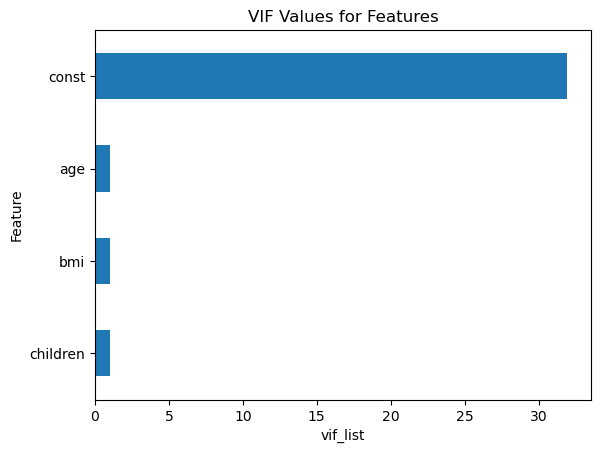

In [21]:
s1_cleaned = pd.Series(vif_list,index = x_constant.columns)
s1_cleaned.sort_values().plot(kind="barh")
plt.xlabel("vif_list")
plt.ylabel("Feature")
plt.title("VIF Values for Features")
plt.show()

In [22]:
x_constant_encoded = pd.get_dummies(x_constant, drop_first=True)  # One-hot encode categorical variables
s1 = pd.Series(vif_list, index=x_constant_encoded.columns)  # Assuming vif_list contains VIF values
s1_cleaned.sort_values().plot(kind="barh")

<Axes: >

#### 4) Feature Engineering

In [ ]:
# treament of missing > .fillna()
# outliers >> either transformation or imputation
# rename

In [23]:
df.rename(columns={"sex":"gender"},inplace=True)

In [24]:
df.head()

,age,gender,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,NaN,16884.92400
1,18,male,33.770,1,no,NaN,1725.55230
2,28,male,33.000,3,no,NaN,4449.46200
3,33,male,22.705,0,no,NaN,21984.47061
4,32,male,28.880,0,no,NaN,3866.85520


In [25]:
df["gender"].replace({"male":0,"female":1},inplace=True)

In [26]:
df["gender"].value_counts()

gender
0    676
1    662
Name: count, dtype: int64

In [27]:
df["smoker"].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [28]:
df["smoker"].replace({"no":0,"yes":1},inplace=True)

In [29]:
df["smoker"].value_counts()

smoker
0    1064
1     274
Name: count, dtype: int64

In [30]:
df.corr()

,age,gender,bmi,children,smoker,region,charges
age,1.000000,0.020856,0.109272,0.042469,-0.025019,NaN,0.299008
gender,0.020856,1.000000,-0.046371,-0.017163,-0.076185,NaN,-0.057292
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,NaN,0.198341
children,0.042469,-0.017163,0.012759,1.000000,0.007673,NaN,0.067998
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,NaN,0.787251
region,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,NaN,1.000000


#### encoding

In [31]:
df.head()

,age,gender,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,NaN,16884.92400
1,18,0,33.770,1,0,NaN,1725.55230
2,28,0,33.000,3,0,NaN,4449.46200
3,33,0,22.705,0,0,NaN,21984.47061
4,32,0,28.880,0,0,NaN,3866.85520


In [32]:
df = pd.get_dummies(df,columns=["region"])
df.head()

,age,gender,bmi,children,smoker,charges
0,19,1,27.900,0,1,16884.92400
1,18,0,33.770,1,0,1725.55230
2,28,0,33.000,3,0,4449.46200
3,33,0,22.705,0,0,21984.47061
4,32,0,28.880,0,0,3866.85520


##### 5. feature selection

In [ ]:
# df.corr()
# vif

In [33]:
df.corr()

,age,gender,bmi,children,smoker,charges
age,1.000000,0.020856,0.109272,0.042469,-0.025019,0.299008
gender,0.020856,1.000000,-0.046371,-0.017163,-0.076185,-0.057292
bmi,0.109272,-0.046371,1.000000,0.012759,0.003750,0.198341
children,0.042469,-0.017163,0.012759,1.000000,0.007673,0.067998
smoker,-0.025019,-0.076185,0.003750,0.007673,1.000000,0.787251
charges,0.299008,-0.057292,0.198341,0.067998,0.787251,1.000000


#### 6) Data spliting

In [34]:
x = df.drop("charges",axis=1)
y = df["charges"]
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=42)

#### 7) Model selection

In [35]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)

LinearRegression()

#### 8) Evaluation

##### 8.1 testing

In [36]:
y_pred_test  = lr_model.predict(x_test) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 33979257.05080821
mean absolue error
 4213.484797807139
r2 score is  0.7811302113434095
adjusted r2 score 0.7769533069797342


#### 8.2 On Training Data

In [37]:
y_pred_train  = lr_model.predict(x_train) # y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 37369582.73531941
mean absolue error
 4210.693655802026
r2 score is  0.7410888590280913
adjusted r2 score 0.739872171335554


#### Ridge

In [38]:
ridge_model = Ridge(alpha=1.0) #  alpha=1. = lambda
ridge_model.fit(x_train,y_train)

Ridge()

In [39]:
# On testing data
y_pred_test  = ridge_model.predict(x_test) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 34019263.31635779
mean absolue error
 4225.741579067905
r2 score is  0.7808725199267703
adjusted r2 score 0.7766906977879682


In [40]:
# on training data
y_pred_train  = ridge_model.predict(x_train) # y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 37372563.81072686
mean absolue error
 4220.180213199274
r2 score is  0.7410682049672597
adjusted r2 score 0.7398514202161659


### Lasso

In [41]:
lasso_model = Lasso(alpha=1.0) #  alpha=1. = lambda
lasso_model.fit(x_train,y_train)

Lasso()

In [42]:
# On testing data
y_pred_test  = lasso_model.predict(x_test) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 33982559.951459646
mean absolue error
 4214.199900921316
r2 score is  0.7811089364471854
adjusted r2 score 0.77693162607404


In [43]:
# on training data
y_pred_train  = lasso_model.predict(x_train) # y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 37369594.353295185
mean absolue error
 4211.058635076288
r2 score is  0.7410887785341937
adjusted r2 score 0.7398720904633957


#### check slope for feature selection

In [44]:
lasso_model.coef_

array([2.57060730e+02, 3.54487134e+00, 3.27500617e+02, 4.26581759e+02,
       2.36474061e+04])

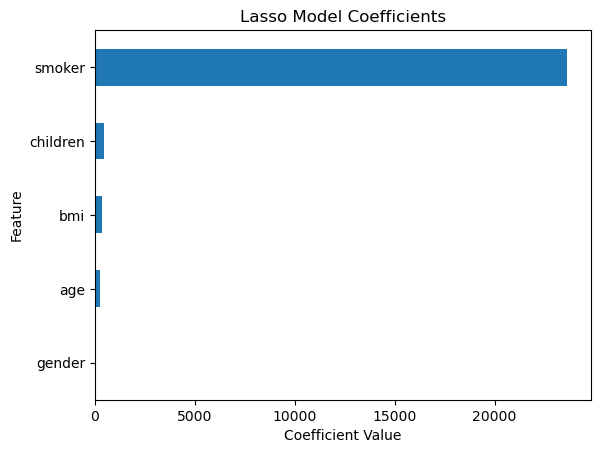

In [45]:
s1 = pd.Series(lasso_model.coef_,index=x.columns)
s1.sort_values().plot(kind="barh")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Lasso Model Coefficients")
plt.show()

In [ ]:
# conclusion : gender has 0 slope therefore we can drop

In [46]:
x_train1 = x_train.drop("gender",axis=1)
lasso_model = Lasso(alpha=1.0) #  alpha=1. = lambda
lasso_model.fit(x_train1,y_train)

Lasso()

In [47]:
# On testing data
x_test1 =  x_test.drop("gender",axis=1)
y_pred_test  = lasso_model.predict(x_test1) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test1.shape[0]-1))/(x_test1.shape[0]-x_test1.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 33983632.03457027
mean absolue error
 4214.339792588865
r2 score is  0.7811020308634791
adjusted r2 score 0.7777727841845966


In [ ]:
# ridge and lasso no change in MSE OR R2

### Hyperparameter Tuning

In [ ]:
# alpha = lambda  =1.0 default

In [48]:
np.arange(0.01,3,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1 ,
       1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 , 1.21,
       1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31, 1.32,
       1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42, 1.43,
       1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.5 , 1.

In [49]:
estimator_ridge = Ridge()
parameter_grid = {"alpha":np.arange(0.01,3,0.01)}
gdsearchCv = GridSearchCV(estimator=estimator_ridge,param_grid=parameter_grid,cv=5)
gdsearchCv.fit(x_train,y_train)
gdsearchCv.best_estimator_

Ridge(alpha=0.92)

In [50]:
# On testing data
ridge_model = gdsearchCv.best_estimator_ # alpha = 0.69
y_pred_test  = ridge_model.predict(x_test) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 34015862.609526634
mean absolue error
 4224.757553734034
r2 score is  0.7808944248196379
adjusted r2 score 0.7767130207131424


In [51]:
# on training data
ridge_model = gdsearchCv.best_estimator_ # alpha = 0.69
y_pred_train  = ridge_model.predict(x_train) # y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 37372108.241612
mean absolue error
 4219.410706860616
r2 score is  0.7410713613289497
adjusted r2 score 0.7398545914103827


#### RandomizedSearchCV

In [52]:
estimator_ridge = Ridge()
parameter_grid = {"alpha":np.arange(0.01,3,0.01)}
rdsearchCv = RandomizedSearchCV(estimator_ridge,parameter_grid,cv=5)
rdsearchCv.fit(x_train,y_train)
rdsearchCv.best_estimator_

Ridge(alpha=0.87)

In [53]:
# On testing data
ridge_model = rdsearchCv.best_estimator_ # alpha = 0.8200000000000001
y_pred_test  = ridge_model.predict(x_test) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 34013754.66443484
mean absolue error
 4224.142072693257
r2 score is  0.780908002676742
adjusted r2 score 0.7767268576896569


In [54]:
# on training data
ridge_model = gdsearchCv.best_estimator_ # 
y_pred_train  = ridge_model.predict(x_train) # y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 37372108.241612
mean absolue error
 4219.410706860616
r2 score is  0.7410713613289497
adjusted r2 score 0.7398545914103827


#### Lasso

In [55]:
estimator_lasso = Lasso()
parameter_grid = {"alpha":np.arange(0.01,3,0.01)}
gdsearchCv = GridSearchCV(estimator=estimator_lasso,param_grid=parameter_grid,cv=5)
gdsearchCv.fit(x_train,y_train)
gdsearchCv.best_estimator_

Lasso(alpha=2.9899999999999998)

In [56]:
# On testing data
lasso_model = gdsearchCv.best_estimator_
y_pred_test  = lasso_model.predict(x_test) # y_test
mse = mean_squared_error(y_test,y_pred_test)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_test,y_pred_test)
print("mean absolue error\n",mae)

r2 = r2_score(y_test,y_pred_test)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_test.shape[0]-1))/(x_test.shape[0]-x_test.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 33987608.42379206
mean absolue error
 4215.416974303864
r2 score is  0.7810764178411788
adjusted r2 score 0.7768984868839494


In [57]:
# on training data
lasso_model = gdsearchCv.best_estimator_
y_pred_train  = lasso_model.predict(x_train) # y_train
mse = mean_squared_error(y_train,y_pred_train)
print("mean squared error\n",mse)

mae = mean_absolute_error(y_train,y_pred_train)
print("mean absolue error\n",mae)

r2 = r2_score(y_train,y_pred_train)
print("r2 score is ",r2)

adj_r2 = 1 - (((1-r2)*(x_train.shape[0]-1))/(x_train.shape[0]-x_train.shape[1]-1))
print("adjusted r2 score",adj_r2)

mean squared error
 37369659.17578996
mean absolue error
 4211.807139637323
r2 score is  0.7410883294184998
adjusted r2 score 0.7398716392371958


#### Final model selected based on MSE and R2 score

In [60]:
import pickle

In [62]:
# lr_model
with open("Linear_model.pkl","wb") as file:
    pickle.dump(lr_model,file)

In [63]:
project_data = {"gender": {"male":0,"female":1},
                "smoker" : {"yes":1,"no":0},
                "columns":list(x.columns)}
project_data

{'gender': {'male': 0, 'female': 1},
 'smoker': {'yes': 1, 'no': 0},
 'columns': ['age', 'gender', 'bmi', 'children', 'smoker']}

In [64]:
import json

In [65]:
with open("project_data.json","w") as file:
    json.dump(project_data,file)

In [66]:
x.columns

Index(['age', 'gender', 'bmi', 'children', 'smoker'], dtype='object')